# INFO 5613 – Class 15: Random networks

[Brian C. Keegan, Ph.D.](http://brianckeegan.com/)  
[Assistant Professor, Department of Information Science](https://www.colorado.edu/cmci/people/information-science/brian-c-keegan)  
University of Colorado Boulder  

Copyright and distributed under an [MIT License](https://opensource.org/licenses/MIT)

## Import libraries

In [1]:
# Load networkx for working with network data
import networkx as nx

# Load numpy for working with numerical data
import numpy as np

# Load pandas for working with tabular data
import pandas as pd

# Load visualization libraries
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sb

# Load libraries
import scipy.stats as stats
import requests
from collections import Counter

# Define a formatting string we can use to print the number of nodes and edges
node_edge_s = "There are {0:,} nodes and {1:,} edges in the network"

You may need to install this library yourself.

`conda install beautifulsoup4`

In [42]:
from bs4 import BeautifulSoup

### *Les Miserables*

Co-apperance of characters in the novel *Les Miserables*.

There are 77 nodes and 254 edges in the network
The density of the graph is: 0.087


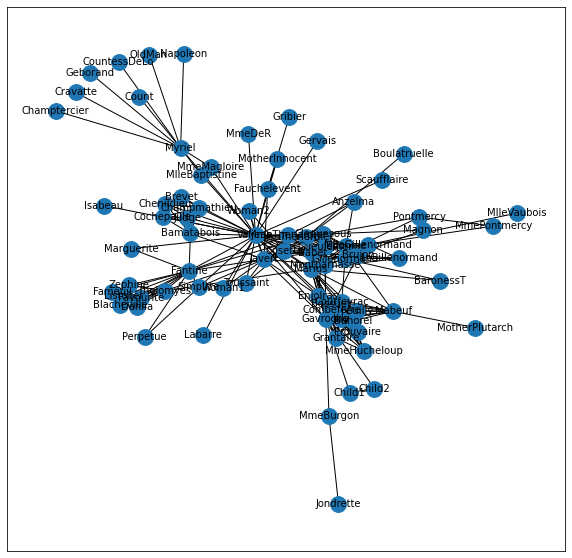

In [2]:
miserables_g = nx.les_miserables_graph()
print(node_edge_s.format(miserables_g.number_of_nodes(),miserables_g.number_of_edges()))
print("The density of the graph is: {0:.3f}".format(nx.density(miserables_g)))

f,ax = plt.subplots(figsize=(10,10))

nx.draw_networkx(
    miserables_g,
    with_labels=True,
    ax=ax,
    node_size=250,
    font_color='k',
    font_size=10
)

In [3]:
pd.Series(nx.degree_centrality(miserables_g)).sort_values(ascending=False)

Valjean        0.473684
Gavroche       0.289474
Marius         0.250000
Javert         0.223684
Thenardier     0.210526
                 ...   
MmeDeR         0.013158
Isabeau        0.013158
Gervais        0.013158
Scaufflaire    0.013158
Napoleon       0.013158
Length: 77, dtype: float64

## Random graph generators

There are many types available: https://networkx.org/documentation/stable/reference/generators.html#module-networkx.generators.random_graphs

### Erdos-Renyi graph ($G_{n,p}$)

Specify a number of nodes N and the probability P of a tie existing between nodes.

There are 100 nodes and 261 edges in the network
The density of the graph is: 0.053


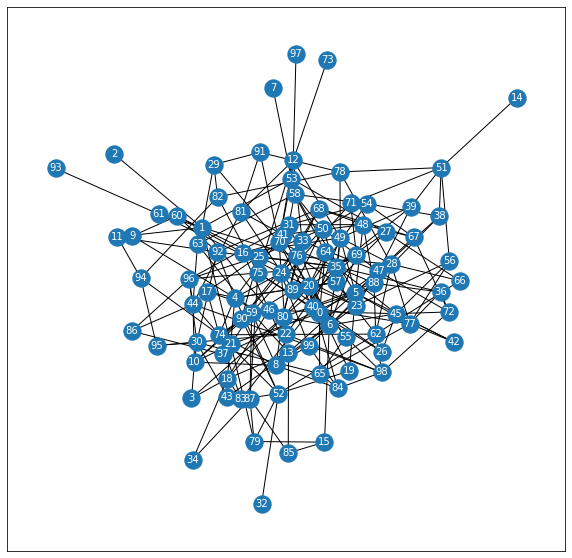

In [43]:
er_g = nx.generators.gnp_random_graph(100,.05)
print(node_edge_s.format(er_g.number_of_nodes(),er_g.number_of_edges()))
print("The density of the graph is: {0:.3f}".format(nx.density(er_g)))

f,ax = plt.subplots(figsize=(10,10))

nx.draw_networkx(
    er_g,
    with_labels=True,
    ax=ax,
    font_color='w',
    font_size=10
)

Make a random network with the same number of nodes and same density/edge probability at the *Les Miserables* network.

There are 77 nodes and 247 edges in the network
The density of the graph is: 0.084


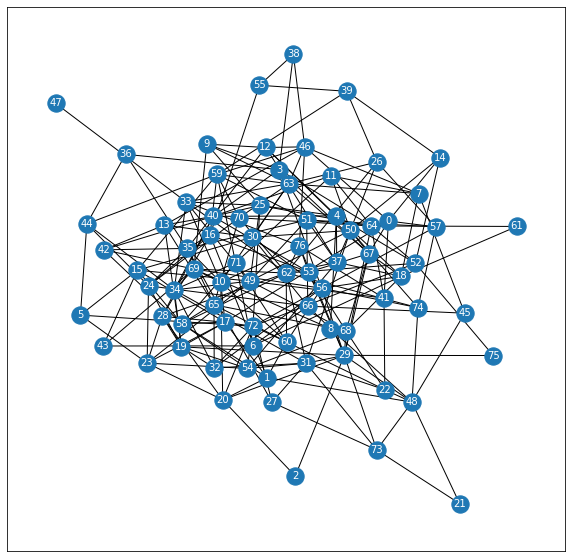

In [55]:
lesmis_node_count = miserables_g.number_of_nodes()
lesmis_edge_prob = nx.density(miserables_g)

lesmis_er_g = nx.generators.gnp_random_graph(lesmis_node_count,lesmis_edge_prob)
print(node_edge_s.format(lesmis_er_g.number_of_nodes(),lesmis_er_g.number_of_edges()))
print("The density of the graph is: {0:.3f}".format(nx.density(lesmis_er_g)))

f,ax = plt.subplots(figsize=(10,10))

nx.draw_networkx(
    lesmis_er_g,
    with_labels=True,
    ax=ax,
    font_color='w',
    font_size=10
)

Compute some statistics to compare the random graph to the original graph.

In [51]:
def mean_degree_centrality(g):
    return np.mean([c*(len(g) - 1) for c in nx.degree_centrality(g).values()])

mean_degree_centrality(miserables_g)

6.597402597402597

In [52]:
statistic_s = "The {0} in the original graph is: {1:.3f}\nThe {0} in the random graph is: {2:.3f}\n"

print(statistic_s.format('average degree centrality',mean_degree_centrality(miserables_g),mean_degree_centrality(lesmis_er_g)))
print(statistic_s.format('average clustering',nx.average_clustering(miserables_g),nx.average_clustering(lesmis_er_g)))
print(statistic_s.format('average shortest path length',nx.average_shortest_path_length(miserables_g),nx.average_shortest_path_length(lesmis_er_g)))
print(statistic_s.format('degree assortativity coefficient',nx.degree_assortativity_coefficient(miserables_g),nx.degree_assortativity_coefficient(lesmis_er_g)))

The average degree centrality in the original graph is: 6.597
The average degree centrality in the random graph is: 6.494

The average clustering in the original graph is: 0.573
The average clustering in the random graph is: 0.080

The average shortest path length in the original graph is: 2.641
The average shortest path length in the random graph is: 2.484

The degree assortativity coefficient in the original graph is: -0.165
The degree assortativity coefficient in the random graph is: -0.033



Compare the degree distributions.

Text(0.5, 0, 'Degree')

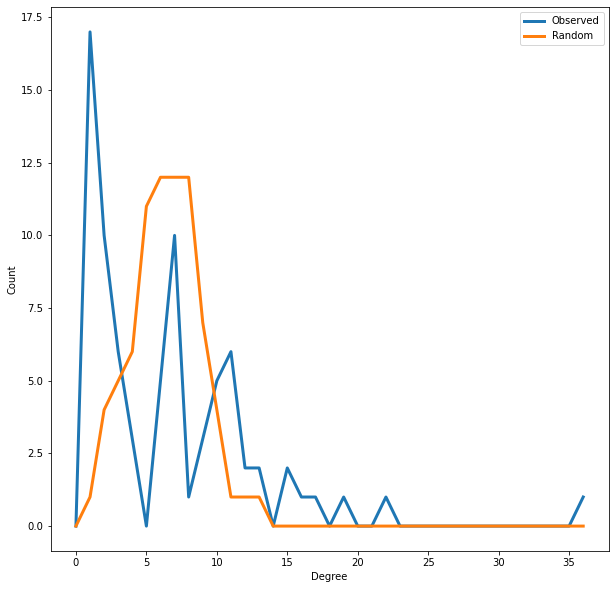

In [56]:
degree_histogram_df = pd.DataFrame({
    'Miserables':pd.Series(nx.degree_histogram(miserables_g)),
    'Random':pd.Series(nx.degree_histogram(lesmis_er_g))
}).fillna(0).reset_index()

f,ax = plt.subplots(figsize=(10,10))
degree_histogram_df.plot.line(x='index',y='Miserables',ax=ax,lw=3,c='tab:blue',label='Observed')
degree_histogram_df.plot.line(x='index',y='Random',ax=ax,lw=3,c='tab:orange',label='Random')

ax.set_ylabel('Count')
ax.set_xlabel('Degree')

In [57]:
# Test whether the distributions are different
stats.ks_2samp(nx.degree_histogram(miserables_g),nx.degree_histogram(lesmis_er_g))

KstestResult(statistic=0.45366795366795365, pvalue=0.019815484118022364)

This was just one random graph, let's make 500 to test whether these statistical properties of the original *Les Miserables* graph differ significantly from random networks.

In [58]:
random_graph_l = []

for i in range(500):
    _g = nx.generators.gnp_random_graph(lesmis_node_count,lesmis_edge_prob)
    random_graph_l.append(_g)

In [59]:
random_graph_stats = {
    'Average degree centrality': list(),
    'Average clustering': list(),
    'Average shortest path': list(),
    'Average assortativity coefficient': list(),
}

for g in random_graph_l:
    random_graph_stats['Average degree centrality'].append(mean_degree_centrality(g))
    random_graph_stats['Average clustering'].append(nx.average_clustering(g))
    
    # Some random networks are not fully connected
    try:
        random_graph_stats['Average shortest path'].append(nx.average_shortest_path_length(g))
    except nx.NetworkXError:
        random_graph_stats['Average shortest path'].append(np.nan)
        
    random_graph_stats['Average assortativity coefficient'].append(nx.degree_assortativity_coefficient(g))

Visualize the observed network against the distribution of random networks.

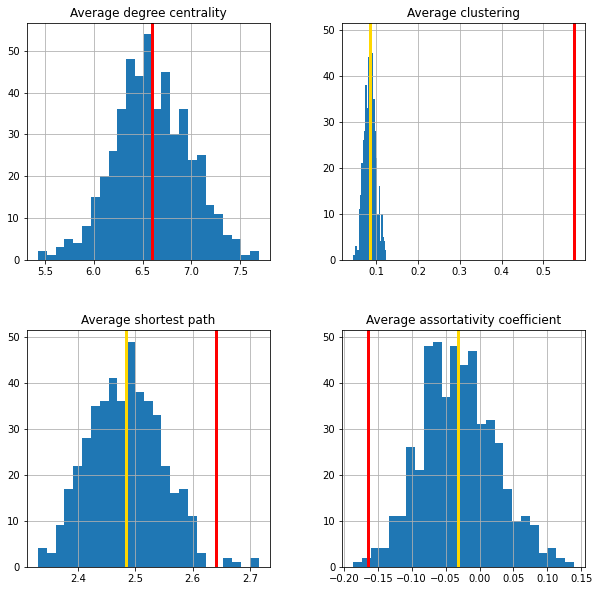

In [60]:
random_graph_stats_df = pd.DataFrame(random_graph_stats)

f,axs = plt.subplots(2,2,figsize=(10,10))
random_graph_stats_df.hist(bins=25,ax=axs)

axs[0,0].axvline(random_graph_stats_df['Average degree centrality'].mean(),c='gold',lw=3)
axs[0,1].axvline(random_graph_stats_df['Average clustering'].mean(),c='gold',lw=3)
axs[1,0].axvline(random_graph_stats_df['Average shortest path'].mean(),c='gold',lw=3)
axs[1,1].axvline(random_graph_stats_df['Average assortativity coefficient'].mean(),c='gold',lw=3)

axs[0,0].axvline(mean_degree_centrality(miserables_g),c='r',lw=3)
axs[0,1].axvline(nx.average_clustering(miserables_g),c='r',lw=3)
axs[1,0].axvline(nx.average_shortest_path_length(miserables_g),c='r',lw=3)
axs[1,1].axvline(nx.degree_assortativity_coefficient(miserables_g),c='r',lw=3)

Report statistical tests.

In [61]:
print("For average degree centrality, the t-statistic is {0:.3f} with a p-value of {1:.3f}\n".format(*stats.ttest_1samp(random_graph_stats_df['Average degree centrality'],mean_degree_centrality(miserables_g))))

print("For average clustering, the t-statistic is {0:.3f} with a p-value of {1:.3f}\n".format(*stats.ttest_1samp(random_graph_stats_df['Average clustering'],nx.average_clustering(miserables_g))))

print("For average shortest path, the t-statistic is {0:.3f} with a p-value of {1:.3f}\n".format(*stats.ttest_1samp(random_graph_stats_df['Average shortest path'],nx.average_shortest_path_length(miserables_g),nan_policy='omit')))

print("For assortativity coefficient, the t-statistic is {0:.3f} with a p-value of {1:.3f}\n".format(*stats.ttest_1samp(random_graph_stats_df['Average assortativity coefficient'],nx.degree_assortativity_coefficient(miserables_g),nan_policy='omit')))

For average degree centrality, the t-statistic is 0.021 with a p-value of 0.983

For average clustering, the t-statistic is -777.089 with a p-value of 0.000

For average shortest path, the t-statistic is -53.487 with a p-value of 0.000

For assortativity coefficient, the t-statistic is 54.764 with a p-value of 0.000



#### $G_{n,m}$ graph

Make a graph with exactly N nodes and M edges.

There are 100 nodes and 250 edges in the network
The density of the graph is: 0.051


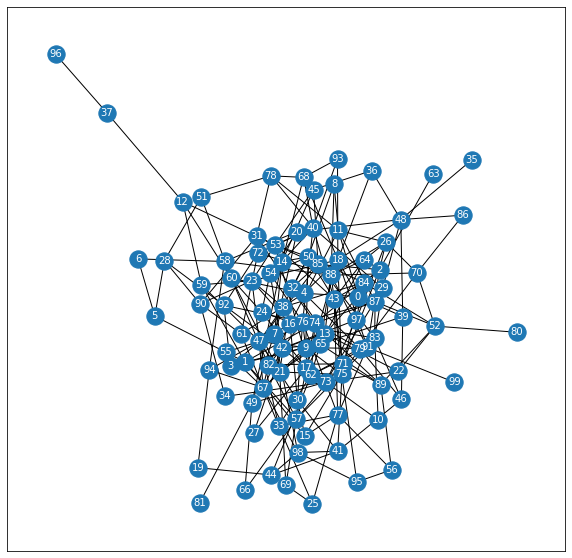

In [62]:
gnm_g = nx.generators.gnm_random_graph(100,250)
print(node_edge_s.format(gnm_g.number_of_nodes(),gnm_g.number_of_edges()))
print("The density of the graph is: {0:.3f}".format(nx.density(gnm_g)))

f,ax = plt.subplots(figsize=(10,10))

nx.draw_networkx(
    gnm_g,
    with_labels=True,
    ax=ax,
    font_color='w',
    font_size=10
)

### Configuration model

Randomly assign edges to match a given degree sequence.

In [63]:
miserables_g.degree()

DegreeView({'Napoleon': 1, 'Myriel': 10, 'MlleBaptistine': 3, 'MmeMagloire': 3, 'CountessDeLo': 1, 'Geborand': 1, 'Champtercier': 1, 'Cravatte': 1, 'Count': 1, 'OldMan': 1, 'Valjean': 36, 'Labarre': 1, 'Marguerite': 2, 'MmeDeR': 1, 'Isabeau': 1, 'Gervais': 1, 'Listolier': 7, 'Tholomyes': 9, 'Fameuil': 7, 'Blacheville': 7, 'Favourite': 7, 'Dahlia': 7, 'Zephine': 7, 'Fantine': 15, 'MmeThenardier': 11, 'Thenardier': 16, 'Cosette': 11, 'Javert': 17, 'Fauchelevent': 4, 'Bamatabois': 8, 'Perpetue': 2, 'Simplice': 4, 'Scaufflaire': 1, 'Woman1': 2, 'Judge': 6, 'Champmathieu': 6, 'Brevet': 6, 'Chenildieu': 6, 'Cochepaille': 6, 'Pontmercy': 3, 'Boulatruelle': 1, 'Eponine': 11, 'Anzelma': 3, 'Woman2': 3, 'MotherInnocent': 2, 'Gribier': 1, 'MmeBurgon': 2, 'Jondrette': 1, 'Gavroche': 22, 'Gillenormand': 7, 'Magnon': 2, 'MlleGillenormand': 7, 'MmePontmercy': 2, 'MlleVaubois': 1, 'LtGillenormand': 4, 'Marius': 19, 'BaronessT': 2, 'Mabeuf': 11, 'Enjolras': 15, 'Combeferre': 11, 'Prouvaire': 9, 'Feuill

In [16]:
# Compute the degree sequence for the Les Miserables network
degree_sequence = [d for n,d in miserables_g.degree()]
degree_sequence

[1,
 10,
 3,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 36,
 1,
 2,
 1,
 1,
 1,
 7,
 9,
 7,
 7,
 7,
 7,
 7,
 15,
 11,
 16,
 11,
 17,
 4,
 8,
 2,
 4,
 1,
 2,
 6,
 6,
 6,
 6,
 6,
 3,
 1,
 11,
 3,
 3,
 2,
 1,
 2,
 1,
 22,
 7,
 2,
 7,
 2,
 1,
 4,
 19,
 2,
 11,
 15,
 11,
 9,
 11,
 13,
 12,
 13,
 12,
 10,
 1,
 10,
 10,
 10,
 9,
 3,
 2,
 2,
 7,
 7]

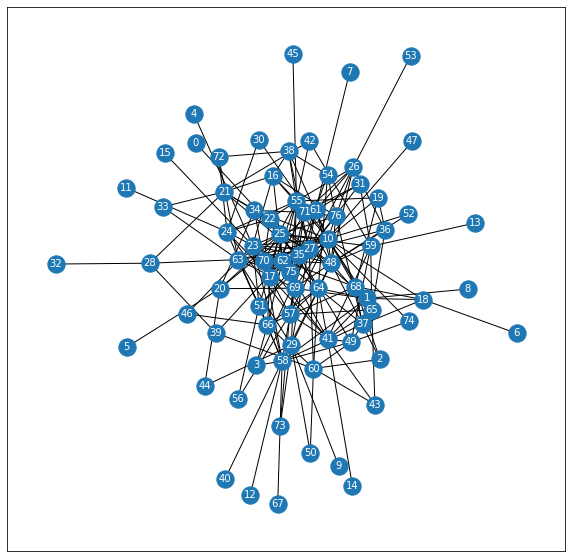

In [67]:
# The configuration_model has two problems
# 1. It can return a MultiGraph, cast back to a simple Graph object
cm_g = nx.Graph(nx.configuration_model(degree_sequence))

# 2. It can include self-loops
cm_g.remove_edges_from(nx.selfloop_edges(cm_g))

f,ax = plt.subplots(figsize=(10,10))

nx.draw_networkx(
    cm_g,
    with_labels=True,
    ax=ax,
    font_color='w',
    font_size=10
)

In [68]:
degree_histogram_df = pd.DataFrame({
    'Miserables':pd.Series(nx.degree_histogram(miserables_g)),
    'Configuration':pd.Series(nx.degree_histogram(cm_g))
}).fillna(0).reset_index()

degree_histogram_df

,index,Miserables,Configuration
0,0,0,0.0
1,1,17,18.0
2,2,10,9.0
3,3,6,6.0
4,4,3,4.0
5,5,0,3.0
6,6,5,4.0
7,7,10,9.0
8,8,1,10.0
9,9,3,2.0


Text(0.5, 0, 'Degree')

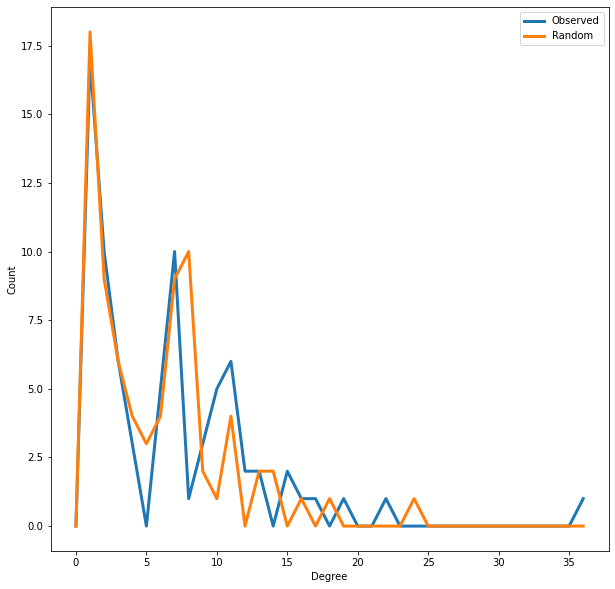

In [69]:
f,ax = plt.subplots(figsize=(10,10))
degree_histogram_df.plot.line(x='index',y='Miserables',ax=ax,lw=3,c='tab:blue',label='Observed')
degree_histogram_df.plot.line(x='index',y='Configuration',ax=ax,lw=3,c='tab:orange',label='Random')

ax.set_ylabel('Count')
ax.set_xlabel('Degree')

In [70]:
# Test whether the distributions are different
stats.ks_2samp(nx.degree_histogram(miserables_g),nx.degree_histogram(cm_g))

KstestResult(statistic=0.15567567567567567, pvalue=0.7930717589884216)

In [71]:
print(statistic_s.format('average degree centrality',mean_degree_centrality(miserables_g),mean_degree_centrality(cm_g)))
print(statistic_s.format('average clustering',nx.average_clustering(miserables_g),nx.average_clustering(cm_g)))
print(statistic_s.format('average shortest path length',nx.average_shortest_path_length(miserables_g),nx.average_shortest_path_length(cm_g)))
print(statistic_s.format('degree assortativity coefficient',nx.degree_assortativity_coefficient(miserables_g),nx.degree_assortativity_coefficient(cm_g)))

The average degree centrality in the original graph is: 6.597
The average degree centrality in the random graph is: 5.662

The average clustering in the original graph is: 0.573
The average clustering in the random graph is: 0.110

The average shortest path length in the original graph is: 2.641
The average shortest path length in the random graph is: 2.665

The degree assortativity coefficient in the original graph is: -0.165
The degree assortativity coefficient in the random graph is: -0.086



### Edge swapping

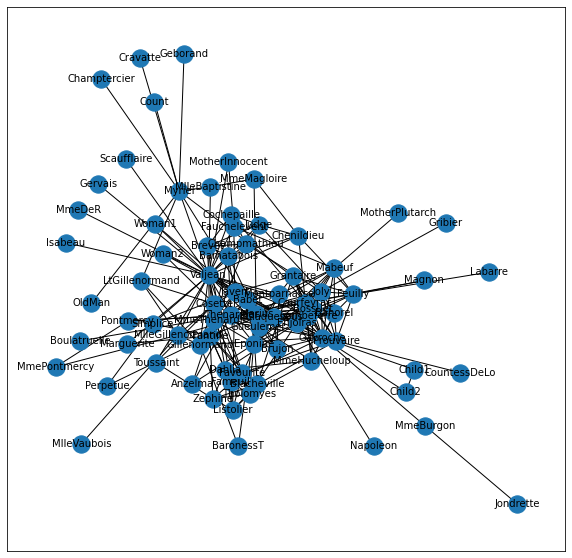

In [22]:
lesmis_swap_g = miserables_g.copy()

nx.swap.connected_double_edge_swap(lesmis_swap_g,nswap=.25*lesmis_swap_g.number_of_edges())

f,ax = plt.subplots(figsize=(10,10))

nx.draw_networkx(
    lesmis_swap_g,
    with_labels=True,
    ax=ax,
    font_color='k',
    font_size=10
)

In [23]:
pd.Series(nx.degree_centrality(lesmis_swap_g)).sort_values(ascending=False)

Valjean        0.473684
Gavroche       0.289474
Marius         0.250000
Javert         0.223684
Thenardier     0.210526
                 ...   
MmeDeR         0.013158
Isabeau        0.013158
Gervais        0.013158
Scaufflaire    0.013158
Napoleon       0.013158
Length: 77, dtype: float64

Text(0.5, 0, 'Degree')

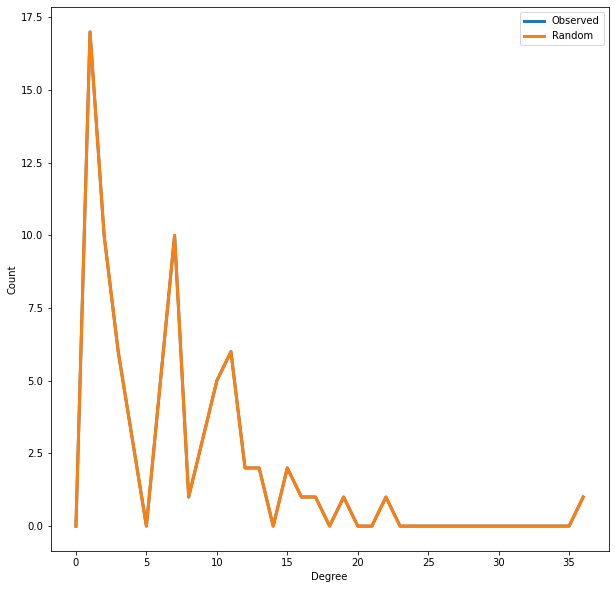

In [24]:
degree_histogram_df = pd.DataFrame({
    'Miserables':pd.Series(nx.degree_histogram(miserables_g)),
    'Configuration':pd.Series(nx.degree_histogram(lesmis_swap_g))
}).fillna(0).reset_index()

f,ax = plt.subplots(figsize=(10,10))
degree_histogram_df.plot.line(x='index',y='Miserables',ax=ax,lw=3,c='tab:blue',label='Observed')
degree_histogram_df.plot.line(x='index',y='Configuration',ax=ax,lw=3,c='tab:orange',label='Random')

ax.set_ylabel('Count')
ax.set_xlabel('Degree')

In [25]:
print(statistic_s.format('average degree centrality',mean_degree_centrality(miserables_g),mean_degree_centrality(lesmis_swap_g)))
print(statistic_s.format('average clustering',nx.average_clustering(miserables_g),nx.average_clustering(lesmis_swap_g)))
print(statistic_s.format('average shortest path length',nx.average_shortest_path_length(miserables_g),nx.average_shortest_path_length(lesmis_swap_g)))
print(statistic_s.format('degree assortativity coefficient',nx.degree_assortativity_coefficient(miserables_g),nx.degree_assortativity_coefficient(lesmis_swap_g)))

The average degree centrality in the original graph is: 6.597
The average degree centrality in the random graph is: 6.597

The average clustering in the original graph is: 0.573
The average clustering in the random graph is: 0.320

The average shortest path length in the original graph is: 2.641
The average shortest path length in the random graph is: 2.526

The degree assortativity coefficient in the original graph is: -0.165
The degree assortativity coefficient in the random graph is: -0.170



## Mediawiki hyperlinks

In [72]:
def get_page_outlinks(page_title, endpoint="en.wikipedia.org/w/api.php"):
    """Takes a page title and returns a list hyperlinks to other articles in the body
    
    page_title - a string with the title of the page on Wikipedia
    endpoint - a string that points to the web address of the API.
        This defaults to the English Wikipedia endpoint: 'en.wikipedia.org/w/api.php'
        Changing the two letter language code will return a different language edition
        The Wikia endpoints are slightly different, e.g. 'starwars.wikia.com/api.php'
    
    Returns:
    links - a list of strings the names of articles
    """
    
    # Get the response from the API for a query
    # After passing a page title, the API returns the HTML markup of the current article version within a JSON payload
        
    query_url = "https://{0}".format(endpoint)
    query_params = {}
    query_params['action'] = 'parse'
    query_params['page'] = page_title
    query_params['prop'] = 'text'
    query_params['format'] = 'json'
    query_params['disableeditsection'] = 1
    query_params['redirects'] = 1
    query_params['formatversion'] = 2

    # Make the query
    json_response = requests.get(url = query_url, params = query_params).json()
    
    # Container to store links
    links = []
    
    # If there is content
    if 'parse' in json_response:
        
        # Convert to soup
        soup = BeautifulSoup(json_response['parse']['text'])
        
        # Find all the paragraph tags
        for p in soup.find_all('p'):
            if len(p.text) > 0:
                
                # Find all the links
                hrefs = p.find_all('a')
                for l in hrefs:
                    
                    if l.has_attr('href') and l.has_attr('title'):
                        if 'wiki' in l['href'] and 'Wikipedia:' not in l['title']:
                            
                            # Add link to links
                            links.append(l['title'])
                
    return links

def get_hyperlink_ego_network(page_title, endpoint="en.wikipedia.org/w/api.php", namespace=0):
    g = nx.DiGraph()
    
    neighbors = get_page_outlinks(page_title)
    
    status = 0
    
    for i,neighbor in enumerate(neighbors):
        if i % int(len(neighbors)/10) == 0:
            print("{0}% complete on {1}".format(status,neighbor))
            status += 10
        
        g.add_edge(page_title,neighbor)
        
        neighbor_neighbors = get_page_outlinks(neighbor)
        
        for nn in neighbor_neighbors:
            if nn in neighbors:
                g.add_edge(neighbor,nn)
    
    return g

In [73]:
wiki_hl_g = get_hyperlink_ego_network('University of Colorado Boulder')

0% complete on Public university
10% complete on Colorado Buffaloes football
20% complete on Travel+Leisure
30% complete on Mary Rippon
40% complete on GPA
50% complete on Blog
60% complete on Hiking
70% complete on Kappa Kappa Gamma
80% complete on NCAA Women's Cross Country Championship
90% complete on College softball


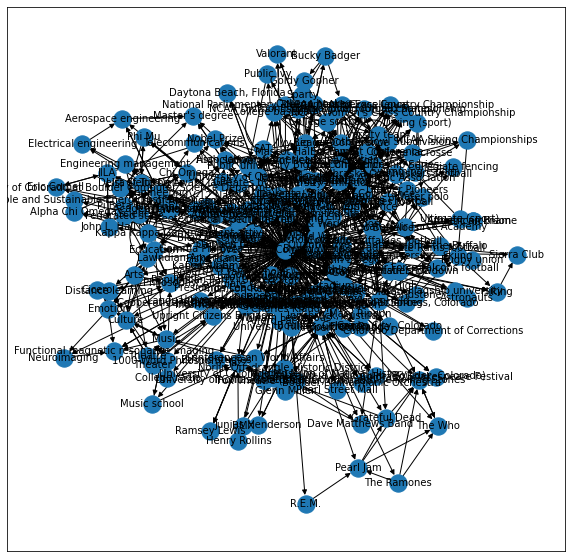

In [28]:
f,ax = plt.subplots(figsize=(10,10))

pos = nx.drawing.kamada_kawai_layout(wiki_hl_g)

nx.draw_networkx(
    wiki_hl_g,
    pos=pos,
    with_labels=True,
    ax=ax,
    font_color='k',
    font_size=10
)

In [29]:
nx.write_gexf(wiki_hl_g,'wikilinks_cuboulder.gexf')

In [74]:
wiki_triad_census = nx.triadic_census(wiki_hl_g)
wiki_triad_census

{'003': 1691624,
 '012': 86345,
 '102': 16492,
 '021D': 24706,
 '021U': 1333,
 '021C': 918,
 '111D': 551,
 '111U': 488,
 '030T': 598,
 '030C': 10,
 '201': 99,
 '120D': 155,
 '120U': 64,
 '120C': 22,
 '210': 46,
 '300': 20}

Make some random graphs.

In [75]:
wiki_gnm_graphs = []
wiki_gcm_graphs = []

for i in range(100):
    gnm = nx.gnm_random_graph(wiki_hl_g.number_of_nodes(),wiki_hl_g.number_of_edges(),directed=True)
    wiki_gnm_graphs.append(gnm)
    
    gcm = nx.DiGraph(nx.generators.directed_configuration_model([d for n,d in wiki_hl_g.in_degree()],[d for n,d in wiki_hl_g.out_degree()]))
    gcm.remove_edges_from(nx.selfloop_edges(gcm))
    wiki_gcm_graphs.append(gcm)

Compute triad censuses.

In [76]:
gnm_triad_census = {}

for i,g in enumerate(wiki_gnm_graphs):
    gnm_triad_census[i] = nx.triadic_census(g)
    
    
gcm_triad_census = {}

for i,g in enumerate(wiki_gcm_graphs):
    gcm_triad_census[i] = nx.triadic_census(g)

General graph statistics.

In [77]:
print(statistic_s.format('reciprocity',nx.reciprocity(wiki_hl_g),nx.reciprocity(wiki_gcm_graphs[0])))
print(statistic_s.format('average degree centrality',mean_degree_centrality(wiki_hl_g),mean_degree_centrality(wiki_gcm_graphs[0])))
print(statistic_s.format('average clustering',nx.average_clustering(wiki_hl_g),nx.average_clustering(wiki_gcm_graphs[0])))
print(statistic_s.format('average shortest path length',nx.average_shortest_path_length(wiki_hl_g),nx.average_shortest_path_length(wiki_gcm_graphs[0])))
print(statistic_s.format('degree assortativity coefficient',nx.degree_assortativity_coefficient(wiki_hl_g),nx.degree_assortativity_coefficient(wiki_gcm_graphs[0])))

The reciprocity in the original graph is: 0.200
The reciprocity in the random graph is: 0.034

The average degree centrality in the original graph is: 7.345
The average degree centrality in the random graph is: 6.251

The average clustering in the original graph is: 0.311
The average clustering in the random graph is: 0.109

The average shortest path length in the original graph is: 1.170
The average shortest path length in the random graph is: 2.242

The degree assortativity coefficient in the original graph is: -0.389
The degree assortativity coefficient in the random graph is: -0.190



Degree distributions.

In [78]:
gnm_idc_counters = {}
gnm_odc_counters = {}

for i,g in enumerate(wiki_gnm_graphs):
    gnm_idc_counters[i] = Counter(dict(g.in_degree()).values())
    gnm_odc_counters[i] = Counter(dict(g.out_degree()).values())
    
    
gcm_idc_counters = {}
gcm_odc_counters = {}

for i,g in enumerate(wiki_gcm_graphs):
    gcm_idc_counters[i] = Counter(dict(g.in_degree()).values())
    gcm_odc_counters[i] = Counter(dict(g.out_degree()).values())

Make histograms and align.

In [79]:
wiki_idc = Counter(dict(wiki_hl_g.in_degree()).values())
wiki_odc = Counter(dict(wiki_hl_g.out_degree()).values())

wiki_idc_histogram = pd.Series(wiki_idc).reset_index().sort_index()
wiki_idc_histogram.columns = ['Degree','Count']
wiki_idc_histogram['Centrality Type'] = 'In-Degree'
wiki_idc_histogram['Graph Type'] = 'Wiki'

wiki_odc_histogram = pd.Series(wiki_odc).reset_index().sort_index()
wiki_odc_histogram.columns = ['Degree','Count']
wiki_odc_histogram['Centrality Type'] = 'Out-Degree'
wiki_odc_histogram['Graph Type'] = 'Wiki'

In [80]:
gnm_idc_histogram_df = pd.DataFrame(gnm_idc_counters).T.sort_index(axis=1).stack().reset_index()
gnm_idc_histogram_df.columns = ['Network','Degree','Count']
gnm_idc_histogram_df['Centrality Type'] = 'In-Degree'
gnm_idc_histogram_df['Graph Type'] = 'GNM'

gnm_odc_histogram_df = pd.DataFrame(gnm_odc_counters).T.sort_index(axis=1).stack().reset_index()
gnm_odc_histogram_df.columns = ['Network','Degree','Count']
gnm_odc_histogram_df['Centrality Type'] = 'Out-Degree'
gnm_odc_histogram_df['Graph Type'] = 'GNM'

gcm_idc_histogram_df = pd.DataFrame(gcm_idc_counters).T.sort_index(axis=1).stack().reset_index()
gcm_idc_histogram_df.columns = ['Network','Degree','Count']
gcm_idc_histogram_df['Centrality Type'] = 'In-Degree'
gcm_idc_histogram_df['Graph Type'] = 'CM'

gcm_odc_histogram_df = pd.DataFrame(gcm_odc_counters).T.sort_index(axis=1).stack().reset_index()
gcm_odc_histogram_df.columns = ['Network','Degree','Count']
gcm_odc_histogram_df['Centrality Type'] = 'Out-Degree'
gcm_odc_histogram_df['Graph Type'] = 'CM'

degree_histogram_df = pd.concat([gnm_idc_histogram_df,gnm_odc_histogram_df,
                                 gcm_idc_histogram_df,gcm_odc_histogram_df,
                                 wiki_idc_histogram,wiki_odc_histogram
                                ])
degree_histogram_df.head()

,Network,Degree,Count,Centrality Type,Graph Type
0,0.0,0,5.0,In-Degree,GNM
1,0.0,1,14.0,In-Degree,GNM
2,0.0,2,43.0,In-Degree,GNM
3,0.0,3,51.0,In-Degree,GNM
4,0.0,4,44.0,In-Degree,GNM


Visualize in and out-distributions of the two random graph models (Erdos-Renyi/GNM and Configuration model) against the wiki.

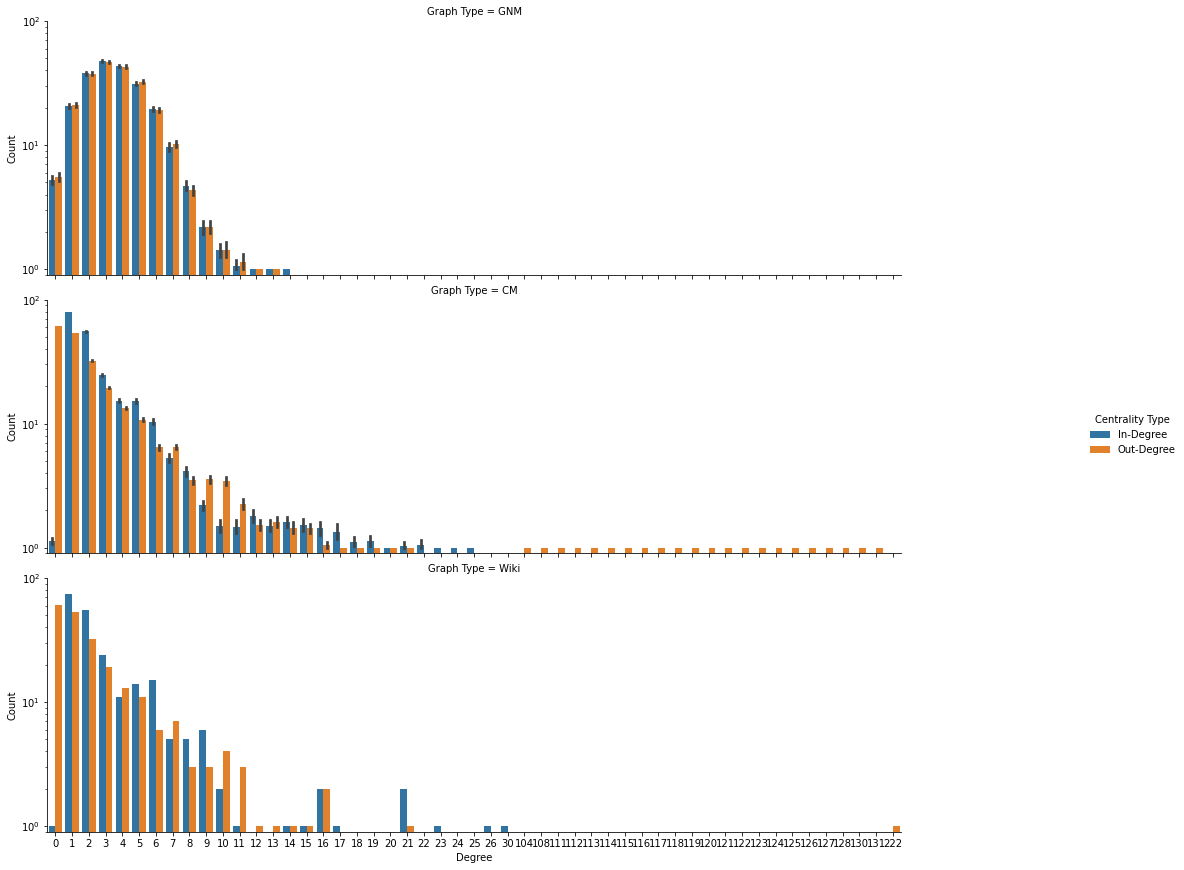

In [81]:
g = sb.catplot(
    x = 'Degree',
    y = 'Count',
    row = 'Graph Type',
    hue = 'Centrality Type',
    data = degree_histogram_df,
    kind = 'bar'
)

g.fig.set_figwidth(18)
g.fig.set_figheight(12)

g.axes[0,0].set_ylim((.9,1e2))
g.axes[0,0].set_yscale('log')

Triadic census on the random graphs.

In [82]:
gnm_triad_census_df = pd.DataFrame(gnm_triad_census).T.stack().reset_index()
gnm_triad_census_df.columns = ['Network','Subgraph','Count']
gnm_triad_census_df['Type'] = 'GNM'

gcm_triad_census_df = pd.DataFrame(gcm_triad_census).T.stack().reset_index()
gcm_triad_census_df.columns = ['Network','Subgraph','Count']
gcm_triad_census_df['Type'] = 'CM'

wiki_triad_census_df = pd.Series(wiki_triad_census).reset_index()
wiki_triad_census_df.columns = ['Subgraph','Count']
wiki_triad_census_df['Network'] = 0
wiki_triad_census_df['Type'] = 'Wiki'

all_triad_census_df = pd.concat([gnm_triad_census_df,gcm_triad_census_df,wiki_triad_census_df])

all_triad_census_df.head()

,Network,Subgraph,Count,Type
0,0,003,1650167,GNM
1,0,012,165778,GNM
2,0,102,1870,GNM
3,0,021D,1362,GNM
4,0,021U,1359,GNM


![](https://ars.els-cdn.com/content/image/1-s2.0-S0378873301000351-gr1.jpg)

In [83]:
all_triad_census_df.pivot_table(values='Count',index='Subgraph',columns='Type')

Type,CM,GNM,Wiki
Subgraph,,,
003,1684921.05,1649868.34,1691624.0
012,124417.75,166372.55,86345.0
021C,2180.59,2786.70,918.0
021D,8145.64,1398.64,24706.0
021U,1332.57,1395.39,1333.0
030C,20.51,15.19,10.0
030T,355.26,47.78,598.0
102,1849.59,1485.22,16492.0
111D,107.40,49.50,551.0


C:\ProgramData\Miniconda3\lib\site-packages\seaborn\categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


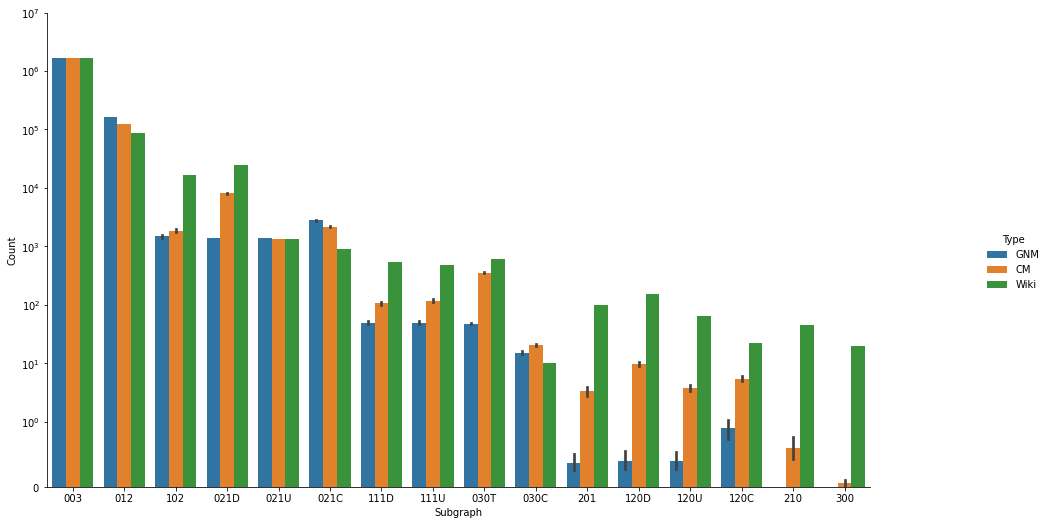

In [84]:
g = sb.catplot(
    x='Subgraph',
    y='Count',
    hue='Type',
    data=all_triad_census_df,
    kind='bar',
    ax=ax
)

g.fig.set_figwidth(16)
g.fig.set_figheight(8)

g.ax.set_ylim((0,1e7))
g.ax.set_yscale('symlog',linthresh=1e0)